# How pravelent are transitive dependencies?
In this notebook, we are going to invsetigate transitive dependencies of Python packages in PyPI.

## Import libraries and load data

In [2]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook, _tqdm_notebook

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
data_folder = '../data/'
requirements = pd.read_csv(data_folder + 'dependencies_all_version_all_time.csv')
requirements.loc[:,'package_name'] = requirements.loc[:,'name']
requirements.loc[:,'requirement'] = requirements.loc[:,'deps']
requirements.loc[:,'package_name'] = requirements.loc[:,'package_name'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'requirement'] = requirements.loc[:,'requirement'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'date'] = requirements.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sub = requirements
data_folder = '../data/'
requirements = pd.read_csv(data_folder + 'reqs.csv')
requirements.loc[:,'package_name'] = requirements.loc[:,'package_name'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'requirement'] = requirements.loc[:,'requirement'].apply(lambda x: x.lower() if type(x)==str else x)

## Define helper functions and defaults

In [4]:
# Helper Functions
def add_three_months(t):
    for i in range(1):
        t = add_a_month(t)
    return t
def add_a_month(t):
    return (t.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)
def print_time(t):
    return t.strftime("%Y-%m-%dT%H:%M:%S")

!mkdir figs
figs_dir = 'figs/'

mkdir: cannot create directory ‘figs’: File exists


In [10]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    plt.rcParams['font.family'] = 'serif'   
    plt.rc('axes', labelsize=8)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    plt.figure(figsize=(4,2.8)) 
    
set_plt_rc()

<Figure size 288x201.6 with 0 Axes>

# Distribution of the number of direct dependencies and the number of transitive dependencies

In [6]:
dep_cache = {}
MAX_LEVEL = 10

def get_direct_deps(p):
    if p in dep_cache:
        return dep_cache[p][1]
    
    direct_deps = list(requirements.loc[requirements.loc[:, 'package_name'] == p, 'requirement'])
    return direct_deps

def get_all_deps(p, level=1, old_deps=None):
    if old_deps is None:
        old_deps = []
    if level > MAX_LEVEL:
        return -1, -1
    if p in dep_cache:
        return dep_cache[p]
    direct_deps = get_direct_deps(p)
    all_deps = []
    for req in direct_deps:
        if req in old_deps:
            continue
        d, _ = get_all_deps(req, level+1, all_deps + old_deps)
        if d == -1:
            return list(set(all_deps)), list(set(direct_deps))
        all_deps += d    
    all_deps += direct_deps
    dep_cache[p] = (list(set(all_deps)), list(set(direct_deps)))
    return list(set(all_deps)), list(set(direct_deps))

def get_transitive_deps(p):
    a,d = get_all_deps(p)
    if a == -1:
        return -1
    return set(a) - set(d)

In [7]:
first_time = sub['date'].min()
last_time = sub['date'].max()
tqdm.pandas()
sub.loc[:,'tran_deps'] = sub.loc[:,'package_name'].progress_apply(get_transitive_deps)
sub.loc[:,'tran_deps_lens'] = sub.loc[:,'tran_deps'].apply(lambda x: len(x))
sub.loc[:,'dir_deps_lens'] = sub.loc[:,'package_name'].apply(lambda x: len(get_direct_deps(x)))
sub.loc[:,'ratios'] = sub.apply(lambda x: x['tran_deps_lens'] / x['dir_deps_lens'], axis=1)
ratio = sub.loc[:,'ratios'].mean()

HBox(children=(IntProgress(value=0, max=2371175), HTML(value='')))

Average ratio between the number of transitive dependencies and the number of direct dependencies:  2.271763550942211


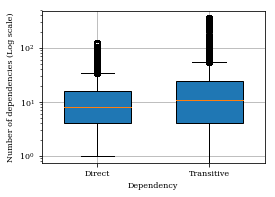

<Figure size 288x201.6 with 0 Axes>

In [29]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2.8))
labels = ['Direct', 'Transitive']
data=[sub['dir_deps_lens'],sub['tran_deps_lens']]
bplot = ax.boxplot(data,vert=True,patch_artist=True,labels=labels,widths=0.6)
ax.set_yscale('log')
ax.set_ylabel('Number of dependencies (Log scale)')
ax.set_xlabel('Dependency')
ax.grid()
fig.savefig(figs_dir+'distribution-of-dependencies', dpi=300,bbox_inches='tight')
set_plt_rc()
print('Average ratio between the number of transitive dependencies and the number of direct dependencies: ',ratio)

# The change of  the ratio over time

In [27]:
project_counts = {}
project_counts['StartDate'] = []
project_counts['EndDate'] = []
project_counts['ratios'] = []
start_time = add_a_month(first_time)
end_time = add_three_months(start_time)
while end_time < last_time.replace(day=1):
    project_counts['StartDate'].append(start_time)
    project_counts['EndDate'].append(end_time)

    idxs = (sub['date'] > start_time) & (sub['date'] < end_time)
    subset = sub.loc[idxs, :]
    ratio = subset.loc[:,'ratios'].mean()
    project_counts['ratios'].append(ratio)
    start_time = end_time
    end_time = add_three_months(start_time)

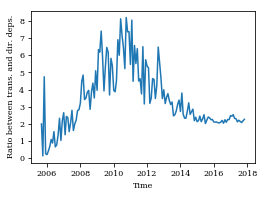

<Figure size 288x201.6 with 0 Axes>

In [30]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(4,2.8))
plt.plot(project_counts['StartDate'], project_counts['ratios'])
plt.xlabel('Time')
plt.ylabel('Ratio between trans. and dir. deps.')
plt.savefig(figs_dir+'dep-ratio-over-time.png', dpi=300,bbox_inches='tight')
set_plt_rc()